In [78]:
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import metrics
#from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import dalex as dx #explainer for our model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV   #Perforing grid search



# Data Engineering

In [2]:
df = pd.read_csv("compas-scores-two-years-clean.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0


In [3]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

In [4]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df = df[columns]

To get a clearer picture, we will only use a few columns of the original data frame.


- demographics: "age", "age_cat", "sex", "race"
- criminal history: "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"
- current charges: "c_charge_degree","c_charge_desc"
- truth:"two_year_recid"


Drop duplicate

In [147]:
df.drop_duplicates()

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid
0,1,69,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Assault w/Firearm,Low,1,NaN,NaN,0
1,3,34,25 - 45,Male,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,Low,3,(F3),Felony Battery (Dom Strang),1
2,4,24,Less than 25,Male,African-American,0,0,1,4,F,Possession of Cocaine,Low,4,(M1),Driving Under The Influence,1
5,7,44,25 - 45,Male,Other,0,0,0,0,M,Battery,Low,1,NaN,NaN,0
6,8,41,25 - 45,Male,Caucasian,0,0,0,14,F,Possession Burglary Tools,Medium,6,(F2),Poss of Firearm by Convic Felo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,20,Less than 25,Male,African-American,0,0,0,0,F,Possession of Cocaine,High,9,NaN,NaN,0
6212,10996,23,Less than 25,Male,African-American,0,0,0,0,F,Deliver Cannabis,Medium,7,NaN,NaN,0
6213,10997,23,Less than 25,Male,African-American,0,0,0,0,F,Leaving the Scene of Accident,Low,3,NaN,NaN,0
6214,10999,57,Greater than 45,Male,Other,0,0,0,0,F,Aggravated Battery / Pregnant,Low,1,NaN,NaN,0


Check dtype of data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


### Feature Engineering: Create feature c_charge_degree_detailed

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee`
- The c_charge_desc contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [6]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df[df["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df[df["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and mapped them against the current charges

### Map charge degree to all cases and store in new feature column c_charge_degree_detailed

In [7]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [8]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df= df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='c_charge_degree_detailed', ylabel='count'>

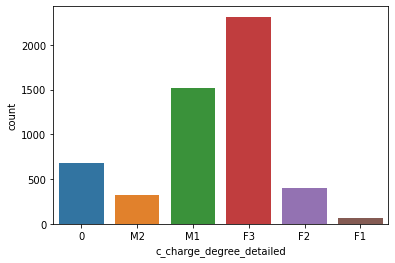

In [9]:
sns.countplot(x="c_charge_degree_detailed", data=df, order=["0","M2", "M1", "F3", "F2", "F1"])

In [10]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [169]:
index_nan_cases = df[df.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges.
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

In [170]:
print(index_nan_cases)

Int64Index([   0,    5,    7,   11,   18,   23,   24,   29,   32,   38,
            ...
            5259, 5261, 5262, 5266, 5274, 5281, 5283, 5285, 5290, 5291],
           dtype='int64', length=1205)


# Data Preprocessing

### Initial distribution of the features

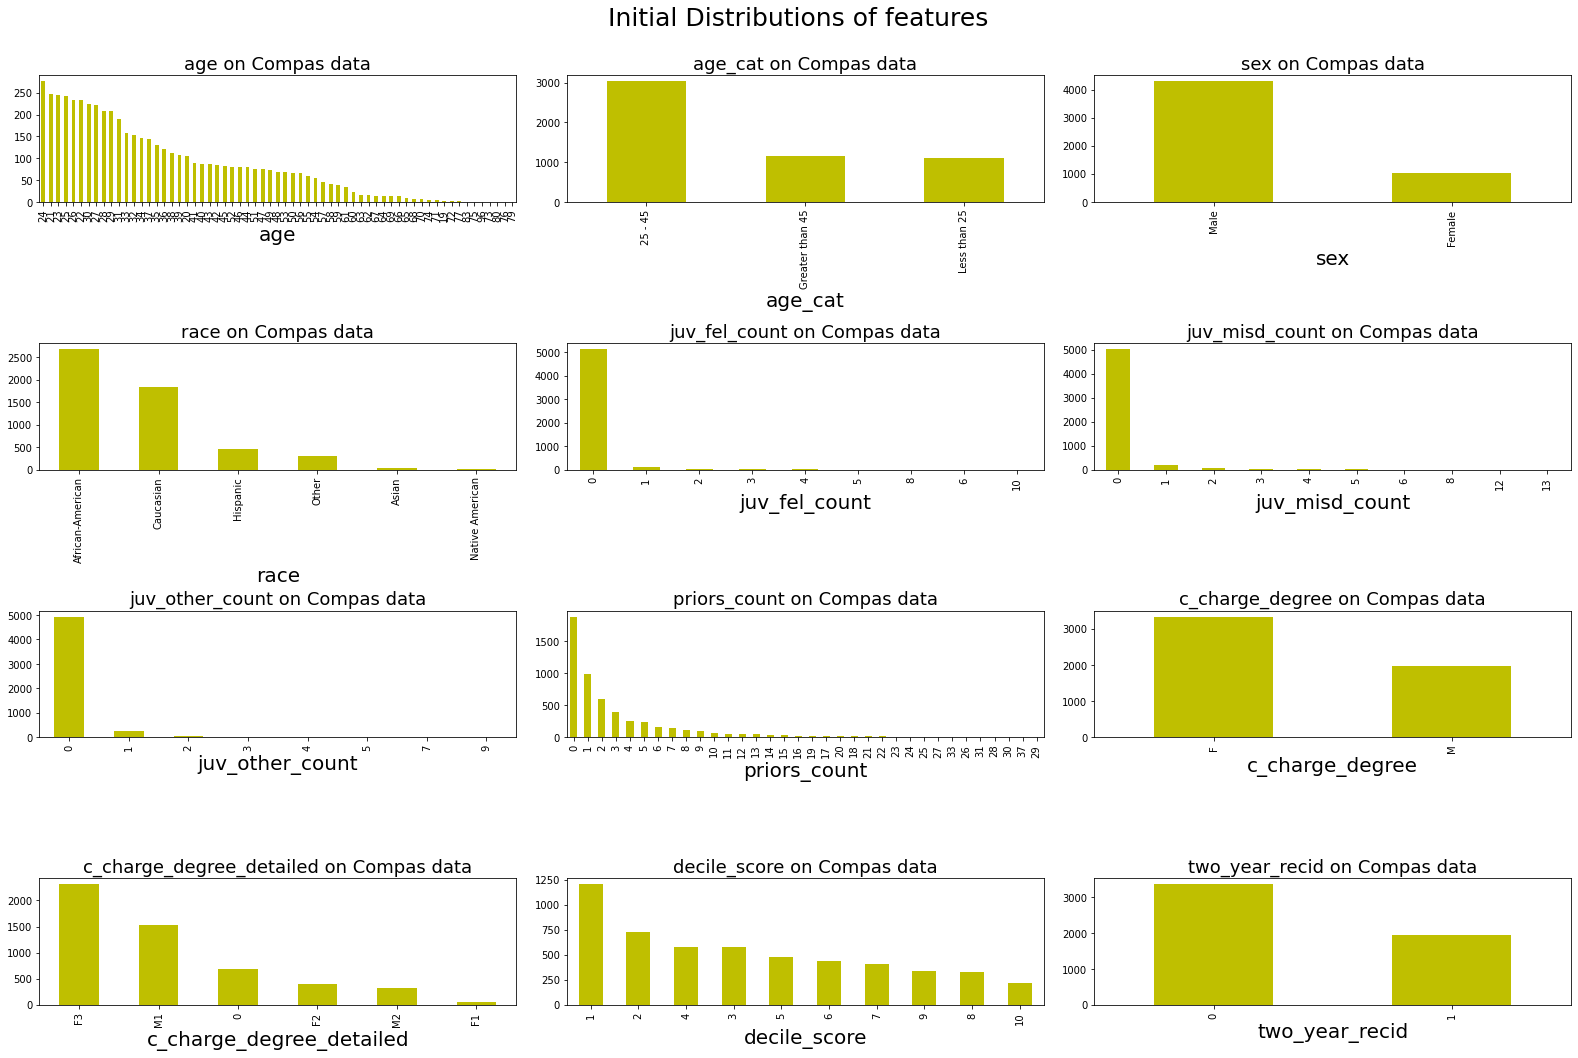

In [17]:

def plot_dist(col, ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='y', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Compas data".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(4,3, figsize = (22,15))
f.tight_layout(h_pad=12, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = [ "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_degree_detailed", #current charges
           "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "two_year_recid"]
k = 0
for i in range(4):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

The imputing of missing values for c_charge_desc will be performed during the preprocessing

In [171]:
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

charge_desc = df['c_charge_desc'].apply(lambda x: x if isinstance(x, str) else '')
count_vectorizer = CountVectorizer(
    max_df=0.85, stop_words='english',
    max_features=100, decode_error='ignore'
)
charge_desc_features = count_vectorizer.fit_transform(charge_desc)

one_hot_encoder = OneHotEncoder()
charge_degree_features = one_hot_encoder.fit_transform(
    df['c_charge_degree']
)


# Model with age cat


**Featuring age cat**

In [41]:
features = pd.concat([pd.get_dummies(df.age_cat, prefix='age_cat',drop_first=True),
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target = df.decile_score

**Featuring age**

In [42]:
features_age = pd.concat([pd.get_dummies(df.age, prefix='age',drop_first=True),
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.race, prefix='race',drop_first=True),  
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    pd.get_dummies(df.c_charge_degree_detailed, prefix = 'degree_desc',drop_first=True),
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count,
                    df.two_year_recid],
                    axis=1)

target_age = df.decile_score

**Splitting age cat**

In [43]:
X = features
y =target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

Function for fitting model

## Model with default params

Model for age cat

In [44]:

xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', random_state=0, 
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True
                        )
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [45]:
exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.035688,2.008902,0.477586,1.589951,1.313895


In [46]:
exp_xgreg.model_parts().plot()

**Splitting for age**

In [47]:
X_age = features_age
y_age = target_age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age,y_age, test_size=0.3, random_state=42)

In [48]:
xg_reg_age = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:squarederror', random_state=0, 
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1,verbosity=0, silent = True)
xg_reg_age.fit(X_train_age,y_train_age)
y_pred_age = xg_reg_age.predict(X_test_age)

In [49]:
exp_xgreg_age = dx.Explainer(xg_reg_age, X_test_age, y_test_age, verbose=False)
exp_xgreg_age.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.059174,2.014739,0.474546,1.632221,1.401214


Since model with age has a higher r2, we continue with age_cat

**Splitting train and test data for age again for further use**

In [50]:
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

## Tuning the number of boosting round (n_estimator)


In [71]:
params_0 = {
    'n_estimators': np.arange(50,150,5)
}
gsearch0 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, objective='reg:linear', random_state=0, 
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent=True),param_grid = params_0, cv=5)
gsearch0.fit(X_train,y_train)
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 65}, 0.46027977254581165)

We go deeper into the range from 60-71 for more granularity

In [ ]:
params_0 = {
    'n_estimators': np.arange(60,71,1)
}
gsearch0 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, objective='reg:linear', random_state=0, 
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0,silent=True),param_grid = params_0, cv=5)
gsearch0.fit(X_train,y_train)
gsearch0.best_params_, gsearch0.best_score_

({'n_estimators': 65}, 0.46027977254581165)

We choose n_estimators = 65 for our model

# Using GridSearch to tune max_depth and min_child_weight

In [52]:
params_1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True),param_grid = params_1, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.46027977254581165)

## Tunning Gamma

Using max_depth and min_child_weight as results of GridSearch above

In [54]:
params_2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', learning_rate=0.1, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True, max_depth=3, min_child_weight=1),param_grid = params_2, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.2}, 0.4604187439138057)

## Tunning subsample and colsample_bytree

Tune subsample and colsample_bytree

In [55]:
params_3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.2, learning_rate=0.1, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, importance_type='gain',
                          max_delta_step=0, verbosity=0, silent = True, max_depth=3, min_child_weight=1),param_grid = params_3, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.4621584156954269)

## Tuning L1 Regulation

In [56]:
params_4 = {
    'reg_alpha':[0, 1, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.2, learning_rate=0.1, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, importance_type='gain',
                          max_delta_step=0, verbosity=0, silent = True, max_depth=3, min_child_weight=1,subsample=0.8,colsample_bytree=0.9),param_grid = params_4, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 0}, 0.4621584156954269)

## Tuning Learning rate

In [58]:
params_5 = {
    'learning_rate':np.arange(0.1,1,0.1)
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.2, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=0.8,colsample_bytree=0.9,
                          max_delta_step=0, verbosity=0, silent = True, max_depth=3, min_child_weight=1, reg_alpha=0),param_grid = params_5, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'learning_rate': 0.1}, 0.4621584156954269)

## Tunning reg_lambda


In [60]:
params_7 = {
    'reg_lambda':np.arange(0,1.5,0.5)
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.2, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, importance_type='gain',subsample=0.8,colsample_bytree=0.9,
                          max_delta_step=0, verbosity=0, silent = True, max_depth=3, min_child_weight=1, reg_alpha=0, learning_rate=0.1),param_grid = params_7, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_lambda': 1.0}, 0.4621584156954269)

## Testing with new tuned parameters

In [61]:
xg_reg_tuned = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0.2, 
                          objective='reg:linear', random_state=0,  n_estimators = 65,
                          seed=123, colsample_bylevel=1, colsample_bynode=1, importance_type='gain',subsample=0.8,colsample_bytree=0.9,
                          verbosity=0, silent = True, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda = 1, learning_rate=0.1)
xg_reg_tuned.fit(X_train, y_train)
y_pred = xg_reg_tuned.predict(X_test)

In [75]:
exp_xgreg_tuned = dx.Explainer(xg_reg_tuned, X_test, y_test, verbose=False)
exp_xgreg_tuned.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,4.027059,2.006753,0.478703,1.593283,1.344496


In [76]:
roc_auc_score(y_test, y_pred)

ValueError: multi_class must be in ('ovo', 'ovr')

In [77]:
print(y_pred)

[2.4183931 5.619749  5.437198  ... 1.8363533 3.1326087 7.4463267]


R2 after tuning XGBoost is 0.49499

In [83]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[100],
    'min_child_weight':[3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 68.83 seconds for 100 candidates parameter settings.


In [86]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             eta=0.3, eval_metric='rmse', gamma=0.4, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [87]:
best_regressor = random_search.best_estimator_

In [88]:
y_pred = best_regressor.predict(X_test)

In [90]:
r2_score(y_test,y_pred)

0.48010528958392007